## Comparing Media Bias Scores

Compares [All Sides Media](https://www.allsides.com/media-bias/media-bias-ratings) bias scores to the numerical ratings reported in [Filter Bubbles, Echo Chambers, and Online News Consumption](https://academic.oup.com/poq/article/80/S1/298/2223402#supplementary-data).

In [87]:
# install necessary packages
!pip install fuzzywuzzy
!pip install python-Levenshtein

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [144]:
# import modules
import pandas as pd
from fuzzywuzzy import fuzz

In [145]:
# open "filter bubble" bias scores from csv
df1 = pd.read_csv('filter-bubbles-bias.csv', sep='\t', encoding='utf-8')
df1 = df1.loc[:, ['orgs', 'sources', 'scores']]
df1.head()

,orgs,sources,scores
0,Times of India,timesofindia.indiatimes.com,0.04
1,The Economist,economist.com,0.12
2,North Jersey.com,northjersey.com,0.14
3,Orange Country Register,ocregister.com,0.15
4,San Jose Mercury News,mercurynews.com,0.17


In [146]:
# open "all sides" bias scores from csv
df2 = pd.read_csv('allsides-media-bias-ratings.csv', encoding='utf-8')

# rename News Source to match with df1
df2 = df2.rename(index=str, columns={"News Source": "orgs", "Media Bias Rating": "bias"})

# convert bias label to numbers
df2['bias'] = df2['bias'].replace({'Left': 1, 'Lean Left': 2, 'Center': 3, 'Lean Right':4, 'Right':5})
df2.head()

,orgs,bias
0,AARP,3
1,ABC News,2
2,Accuracy in Media,5
3,ACLU,2
4,Al Cardenas,5


In [147]:
# combine dataframes
def combine_df(df1, df2):
    # merge dfs
    combine = pd.merge(df1, df2, how='outer', on="orgs")
    
    return combine
  
combine = combine_df(df2, df1)
combine.head()

,orgs,bias,sources,scores
0,AARP,3,NaN,NaN
1,ABC News,2,abcnews.go.com,0.48
2,Accuracy in Media,5,NaN,NaN
3,ACLU,2,NaN,NaN
4,Al Cardenas,5,NaN,NaN


### Merge Non-Identical Media Listings with Fuzzy Matching

In [82]:
# select orgs with missing scores
missing_scores = combine[combine.bias.isnull()]

# display results
missing_scores.reset_index(inplace=True,drop='index')
missing_scores.head()

,orgs,bias,sources,scores
0,Times of India,NaN,timesofindia.indiatimes.com,0.04
1,North Jersey.com,NaN,northjersey.com,0.14
2,Orange Country Register,NaN,ocregister.com,0.15
3,NewJersey.com,NaN,nj.com,0.17
4,Baltimore Sun,NaN,baltimoresun.com,0.19


In [90]:
# define function for string matching
def match_name(name, list_names, min_score=0):
    # -1 score for no matches
    max_score = -1
    # return empty name for no match
    max_name = ""
    # iternate over all names 
    for name2 in list_names:
        # compute fuzzy match score
        score = fuzz.ratio(name, name2)
        # check if above threshold + better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

In [89]:
# iterate over orgs without scores
dict_list = []
for name in missing_scores.orgs:
    # find best match above threshold
    match = match_name(name, df2.orgs, 75)
    
    # store data to dict
    dict_ = {}
    if match[1] > 0:
      dict_.update({"org_name" : name})
      dict_.update({"match_name" : match[0]})
      dict_.update({"score" : match[1]})
      dict_list.append(dict_)
    
merge_table = pd.DataFrame(dict_list)
# Display results
merge_table

,match_name,org_name,score
0,Orange County Register,Orange Country Register,98
1,The Jerusalem Post,Jerusalem Post,88
2,CU Independent,The Independent,83
3,Wall Street Journal- News,Wall Street Journal News.com (AU),83
4,U.S. News & World Report,US News and World Report,88
5,AlterNet,Alternet,88
6,Raw Story,The Raw Story,82
7,Los Angeles Times,Los Angleles Times,97
8,RealClearPolitics,Real Clear Politics,94
9,Yahoo News,Yahoo! News,95


In [123]:
# translate merge table into a dictionary
match_dict = dict(zip(merge_table.org_name, merge_table.match_name))
match_dict

{'Alternet': 'AlterNet',
 'Breitbart': 'Breitbart News',
 'Jerusalem Post': 'The Jerusalem Post',
 'Los Angleles Times': 'Los Angeles Times',
 'NBC News': 'ABC News',
 'Orange Country Register': 'Orange County Register',
 'Real Clear Politics': 'RealClearPolitics',
 'Reason Magazine': 'Yes! Magazine',
 'The Independent': 'CU Independent',
 'The National Review': 'National Review',
 'The Raw Story': 'Raw Story',
 'US News and World Report': 'U.S. News & World Report',
 'Wall Street Journal News.com (AU)': 'Wall Street Journal- News',
 'Yahoo! News': 'Yahoo News',
 'factcheck.org': 'FactCheck.org'}

In [157]:
# update df1 with match values
def update_df(df):
  for key in match_dict:
    df['orgs'] = df['orgs'].replace(key, match_dict[key])
  return df

df1 = update_df(df1)

In [158]:
# try combining the two dfs again
combine = pd.merge(df1, df2, how='inner', on="orgs")

In [159]:
# check that the merge has produced more matches
len(combine)

43

In [160]:
combine.head()

,orgs,sources,scores,bias
0,The Economist,economist.com,0.12,2
1,Orange County Register,ocregister.com,0.15,4
2,San Jose Mercury News,mercurynews.com,0.17,2
3,San Francisco Chronicle,sfgate.com,0.19,1
4,The Jerusalem Post,jpost.com,0.25,3


### Examine Relationship

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


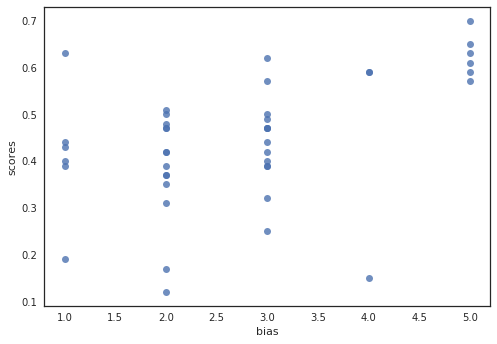

In [135]:
# plot relationship
import seaborn as sns
sns.regplot(x=combine["bias"], y=combine["scores"], fit_reg=False)

In [161]:
combine.head()

,orgs,sources,scores,bias
0,The Economist,economist.com,0.12,2
1,Orange County Register,ocregister.com,0.15,4
2,San Jose Mercury News,mercurynews.com,0.17,2
3,San Francisco Chronicle,sfgate.com,0.19,1
4,The Jerusalem Post,jpost.com,0.25,3


In [172]:
#sns.lmplot(x="bias", y="scores", data=combine, fit_reg=False, size=30, aspect=2)

#plt.title('Example Plot')
# Set x-axis label
#plt.xlabel('All Sides Bias')
# Set y-axis label
#plt.ylabel('Filter Bubble Score')

#def label_point(x, y, val, ax):
 #   a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  #  for i, point in a.iterrows():
   #     ax.text(point['x']+0.3, point['y'], str(point['val']))

#label_point(combine.scores, combine.bias, combine.orgs, plt.gca())  

In [136]:
# plot correlation
import numpy as np

df_dummies = pd.get_dummies(combine['bias'])
del df_dummies[df_dummies.columns[-1]]
df_new = pd.concat([df, df_dummies], axis=1)
del df_new['orgs']
del df_new['sources']
df_new = df_new.iloc[0:28]
df_new.head()

,scores,1,2,3,4
0,0.04,0.0,1.0,0.0,0.0
1,0.12,0.0,0.0,0.0,1.0
2,0.14,0.0,1.0,0.0,0.0
3,0.15,1.0,0.0,0.0,0.0
4,0.17,0.0,0.0,1.0,0.0


In [137]:
x = df_new.values
correlation_matrix = np.corrcoef(x.T)
print(correlation_matrix)

[[ 1.          0.0391738  -0.15103649  0.24594014 -0.31309753]
 [ 0.0391738   1.         -0.40378643 -0.34752402 -0.08973032]
 [-0.15103649 -0.40378643  1.         -0.64549722 -0.16666667]
 [ 0.24594014 -0.34752402 -0.64549722  1.         -0.14344383]
 [-0.31309753 -0.08973032 -0.16666667 -0.14344383  1.        ]]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


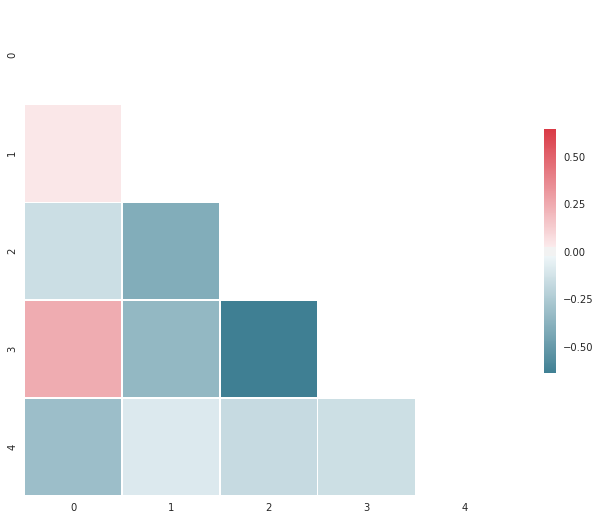

In [138]:
from string import ascii_letters
import matplotlib.pyplot as plt

sns.set(style="white")
# Compute the correlation matrix
corr = correlation_matrix

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})